In [2]:
!pip install mlflow

## Test MLflow

In [3]:
import mlflow

# Use the URL of the instance you have created
mlflow.set_tracking_uri("http://localhost:5000")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

🏃 View run legendary-mare-544 at: http://localhost:5000/#/experiments/0/runs/9af6b004f7fc4dd7b2c2942ac5dfb450
🧪 View experiment at: http://localhost:5000/#/experiments/0


## 1. Creating Baseline Model
Initial models like Random Forest are established to provide a performance benchmark.

In [4]:
import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/nakibworkspace/Youtube-Sentiment-Insights/refs/heads/main/Data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


Now we will perform some preprocessing work that we have done before but now to train the models.

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df= df[~(df['clean_comment'].str.strip() == '')]

In [9]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.4 MB/s eta 0:00:0031m12.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 16.4 MB/s eta 0:00:0031m22.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.5 MB/s eta 0:00:00


In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [14]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/poridhian/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/poridhian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [16]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [17]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [19]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.9 MB/s eta 0:00:006.7 MB/s eta 0:00:01


In [20]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Vectorize the comments using Bag of Words (CountVectorizer)

In [21]:
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [22]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [23]:
X
X.shape

(36793, 10000)

In [24]:
y
y.shape

(36793,)

### Step 2: Set up the MLflow tracking server

In [25]:
# Use the URL of the instance you have created
mlflow.set_tracking_uri("http://localhost:5000")

Set or create an experiment

In [26]:
mlflow.set_experiment("RF Baseline")

2026/01/14 20:58:00 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1768424280169, experiment_id='1', last_update_time=1768424280169, lifecycle_stage='active', name='RF Baseline', tags={}>

In [27]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 33.3 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00


### Step 3: Model Training

2026/01/14 21:03:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://localhost:5000/#/experiments/1/runs/bd975f7a343548a5ac902ae6414f2c8e
🧪 View experiment at: http://localhost:5000/#/experiments/1
Accuracy: 0.6479141187661367


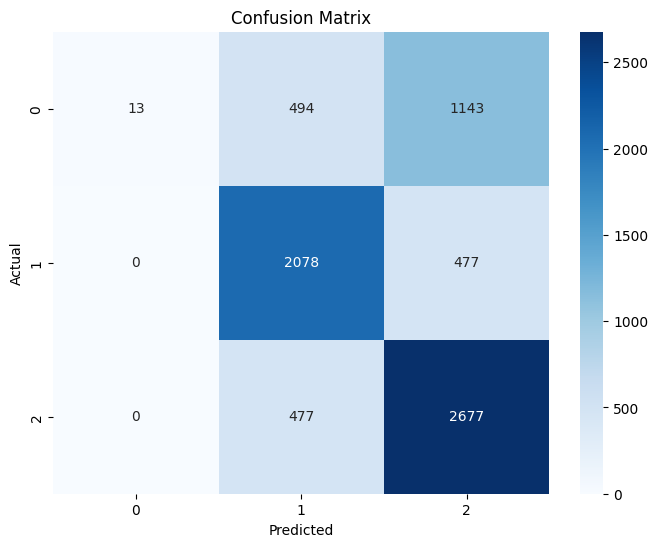

In [28]:
# 3.1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3.2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [30]:
df.to_csv('reddit_preprocessing.csv', index=False)

In [31]:
pd.read_csv('reddit_preprocessing.csv').head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


## 2. BoW vs TFIdf
The experiments compare two fundamental text vectorization methods:

**Bag of Words (BoW)**: Uses CountVectorizer to create a numerical representation of the text based on word frequency. In this lab, it is configured with a limit of 10,000 features.

**TF-IDF**: While not explicitly shown in the early BoW setup, the later parts of the notebook use X_train_tfidf_cleaned, indicating a shift to Term Frequency-Inverse Document Frequency. This method weighs words based on how unique they are to a specific document compared to the entire corpus, typically providing better context for models.

In [32]:
import mlflow
# Set up the MLflow tracking server
# Use the URL of the instance you have created
# mlflow.set_tracking_uri("http://ec2-54-175-41-29.compute-1.amazonaws.com:5000/")
mlflow.set_tracking_uri("http://localhost:5000")

In [33]:
# Set or create an experiment
mlflow.set_experiment("BoW vs TfIdf")

2026/01/14 21:03:35 INFO mlflow.tracking.fluent: Experiment with name 'BoW vs TfIdf' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1768424615455, experiment_id='2', last_update_time=1768424615455, lifecycle_stage='active', name='BoW vs TfIdf', tags={}>

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [35]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [36]:

# Step 1: Function to run the experiment
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # Step 2: Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")

# Step 6: Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")


2026/01/14 21:03:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run BoW_(1, 1)_RandomForest at: http://localhost:5000/#/experiments/2/runs/468c3fe6737a4bd38777d5a25e018fa8
🧪 View experiment at: http://localhost:5000/#/experiments/2


2026/01/14 21:03:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TF-IDF_(1, 1)_RandomForest at: http://localhost:5000/#/experiments/2/runs/0664832e24054677b7d22cca04d2f986
🧪 View experiment at: http://localhost:5000/#/experiments/2


2026/01/14 21:04:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run BoW_(1, 2)_RandomForest at: http://localhost:5000/#/experiments/2/runs/ff7aeb3ae5884a31b231a7e96157af18
🧪 View experiment at: http://localhost:5000/#/experiments/2


2026/01/14 21:04:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TF-IDF_(1, 2)_RandomForest at: http://localhost:5000/#/experiments/2/runs/400c5dbcf9d14d13860618097bf337db
🧪 View experiment at: http://localhost:5000/#/experiments/2


2026/01/14 21:04:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run BoW_(1, 3)_RandomForest at: http://localhost:5000/#/experiments/2/runs/7496706e4a244695853e9089d3e61d9a
🧪 View experiment at: http://localhost:5000/#/experiments/2


2026/01/14 21:04:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TF-IDF_(1, 3)_RandomForest at: http://localhost:5000/#/experiments/2/runs/86f790f29e754073879c1cc5f4a6a1e8
🧪 View experiment at: http://localhost:5000/#/experiments/2


## 3. TfIdf Trigram
In the advanced modeling stage, the lab likely utilizes n-grams (specifically trigrams) within the TF-IDF vectorizer. This allows the model to consider sequences of three words (e.g., "not very good") rather than just individual words, which is crucial for capturing nuanced sentiment and negation.

In [37]:
import mlflow
# Step 2: Set up the MLflow tracking server
# Use the URL of the instance you have created
# mlflow.set_tracking_uri("http://ec2-54-175-41-29.compute-1.amazonaws.com:5000/")
mlflow.set_tracking_uri("http://localhost:5000")

In [38]:
# Set or create an experiment
mlflow.set_experiment("TfIdf Trigram max_features")

2026/01/14 21:05:01 INFO mlflow.tracking.fluent: Experiment with name 'TfIdf Trigram max_features' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1768424701813, experiment_id='3', last_update_time=1768424701813, lifecycle_stage='active', name='TfIdf Trigram max_features', tags={}>

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [40]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [41]:
# Step 1: Function to run the experiment
def run_experiment_tfidf_max_features(max_features):
    ngram_range = (1, 3)  # Trigram setting

    # Step 2: Vectorization using TF-IDF with varying max_features
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"TFIDF_Trigrams_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, max_features={max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, max_features={max_features}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_{max_features}")

# Step 6: Test various max_features values
max_features_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_features_values:
    run_experiment_tfidf_max_features(max_features)

2026/01/14 21:05:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_1000 at: http://localhost:5000/#/experiments/3/runs/b9cea8d2c0064bbfb65e8fde37fd5fb1
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:05:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_2000 at: http://localhost:5000/#/experiments/3/runs/bb9c6f611678437c9f71212ee1a05be6
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:05:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_3000 at: http://localhost:5000/#/experiments/3/runs/b3b29589b1d54c86a6842bd1dc1fedb8
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:06:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_4000 at: http://localhost:5000/#/experiments/3/runs/2c32419e5da840c58b70e2b55ee0a3b0
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:06:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_5000 at: http://localhost:5000/#/experiments/3/runs/dbfa35b6fc7a4c498b78b6b985d2d501
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:06:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_6000 at: http://localhost:5000/#/experiments/3/runs/fa12cfb4f72a47709fe27d1d9f574eb6
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:07:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_7000 at: http://localhost:5000/#/experiments/3/runs/530f45aea34f47b88377d5a59dfe4a84
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:07:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_8000 at: http://localhost:5000/#/experiments/3/runs/e2fc6d0c2f8b4b92a227774987317b34
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:07:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_9000 at: http://localhost:5000/#/experiments/3/runs/a8f9eb3de5a04720b9de482385358edb
🧪 View experiment at: http://localhost:5000/#/experiments/3


2026/01/14 21:07:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TFIDF_Trigrams_max_features_10000 at: http://localhost:5000/#/experiments/3/runs/a07fe8e6e92041688d772c851e194d9b
🧪 View experiment at: http://localhost:5000/#/experiments/3


## 4. Handling Imbalanced Data
The notebook addresses potential class imbalances (where one sentiment might have significantly more samples than others) by using Stratified K-Fold cross-validation. This ensures that each fold used during training and validation maintains the same percentage of samples for each target class as the complete set, leading to more reliable evaluation metrics like the macro-averaged F1-score.

In [1]:
!pip install imblearn

In [2]:
import mlflow
# Step 2: Set up the MLflow tracking server
# Use the URL of the instance you have created
# mlflow.set_tracking_uri("http://ec2-54-175-41-29.compute-1.amazonaws.com:5000/")
mlflow.set_tracking_uri("http://localhost:5000/")

In [3]:
# Set or create an experiment
mlflow.set_experiment("Handling Imbalanced Data")

<Experiment: artifact_location='mlflow-artifacts:/4', creation_time=1768424889430, experiment_id='4', last_update_time=1768424889430, lifecycle_stage='active', name='Handling Imbalanced Data', tags={}>

In [4]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [5]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [6]:
# Step 1: Function to run the experiment
def run_imbalanced_experiment(imbalance_method):
    ngram_range = (1, 3)  # Trigram setting
    max_features = 10000  # Set max_features to 1000 for TF-IDF

    # Step 4: Train-test split before vectorization and resampling
    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    # Step 2: Vectorization using TF-IDF, fit on training data only
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
    X_test_vec = vectorizer.transform(X_test)  # Transform test data

    # Step 3: Handle class imbalance based on the selected method (only applied to the training set)
    if imbalance_method == 'class_weights':
        # Use class_weight in Random Forest
        class_weight = 'balanced'
    else:
        class_weight = None  # Do not apply class_weight if using resampling

        # Resampling Techniques (only apply to the training set)
        if imbalance_method == 'oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'undersampling':
            rus = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'smote_enn':
            smote_enn = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)

    # Step 5: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"Imbalance_{imbalance_method}_RandomForest_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "imbalance_handling")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, imbalance handling method={imbalance_method}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("imbalance_method", imbalance_method)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, class_weight=class_weight)
        model.fit(X_train_vec, y_train)

        # Step 6: Make predictions and log metrics
        y_pred = model.predict(X_test_vec)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, Imbalance={imbalance_method}")
        confusion_matrix_filename = f"confusion_matrix_{imbalance_method}.png"
        plt.savefig(confusion_matrix_filename)
        mlflow.log_artifact(confusion_matrix_filename)
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_imbalance_{imbalance_method}")

# Step 7: Run experiments for different imbalance methods
imbalance_methods = ['class_weights', 'oversampling', 'adasyn', 'undersampling', 'smote_enn']

for method in imbalance_methods:
    run_imbalanced_experiment(method)


2026/01/14 21:12:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Imbalance_class_weights_RandomForest_TFIDF_Trigrams at: http://localhost:5000/#/experiments/4/runs/035d3f77949740d5a4c31ce0a81e6ceb
🧪 View experiment at: http://localhost:5000/#/experiments/4


2026/01/14 21:12:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Imbalance_oversampling_RandomForest_TFIDF_Trigrams at: http://localhost:5000/#/experiments/4/runs/e3522dc63e06487d80cdd161f82583dc
🧪 View experiment at: http://localhost:5000/#/experiments/4


2026/01/14 21:13:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Imbalance_adasyn_RandomForest_TFIDF_Trigrams at: http://localhost:5000/#/experiments/4/runs/a7053e6bceb144e19f53bab61b9516fe
🧪 View experiment at: http://localhost:5000/#/experiments/4


2026/01/14 21:13:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Imbalance_undersampling_RandomForest_TFIDF_Trigrams at: http://localhost:5000/#/experiments/4/runs/be99dca0c70e460999d2c58383b09c77
🧪 View experiment at: http://localhost:5000/#/experiments/4


2026/01/14 21:14:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Imbalance_smote_enn_RandomForest_TFIDF_Trigrams at: http://localhost:5000/#/experiments/4/runs/471153ebf80443e3859981c9dc83a7fc
🧪 View experiment at: http://localhost:5000/#/experiments/4


## 5. ML Algos with HP Tuning
This section demonstrates how to optimize models using MLflow to track different parameter configurations.

**Process:** It defines specific parameters (e.g., param1) and logs them alongside performance metrics (like accuracy) for every run.

**Algorithms:** It applies this to various models, starting from a Random Forest baseline to more complex estimators.

In [7]:
import mlflow
# Step 2: Set up the MLflow tracking server
# Use the URL of the instance you have created
# mlflow.set_tracking_uri("http://ec2-54-196-109-131.compute-1.amazonaws.com:5000/")
mlflow.set_tracking_uri("http://localhost:5000")

In [8]:
# Set or create an experiment
mlflow.set_experiment("ML Algos with HP Tuning")

2026/01/14 21:14:38 INFO mlflow.tracking.fluent: Experiment with name 'ML Algos with HP Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/5', creation_time=1768425278895, experiment_id='5', last_update_time=1768425278895, lifecycle_stage='active', name='ML Algos with HP Tuning', tags={}>

In [12]:
!pip install optuna xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 15.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.6 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 6.3 MB/s eta 0:00:000m eta 0:00:010:00:01


In [13]:
import optuna
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [14]:
df = pd.read_csv('reddit_preprocessing.csv').dropna()
df.shape

(36662, 2)

In [17]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['category'] = df['category'].map({-1: 2, 0: 0, 1: 1})

# Step 2: Remove rows where the target labels (category) are NaN
df = df.dropna(subset=['category'])

ngram_range = (1, 2)  # Bigram instead of trigram (faster)
max_features = 3000  # Reduced from 10000 to 3000

# Step 4: Train-test split before vectorization and resampling
X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# Step 2: Vectorization using TF-IDF, fit on training data only
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
X_test_vec = vectorizer.transform(X_test)  # Transform test data

smote = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

# Function to log results in MLflow
def log_mlflow(model_name, model, X_train, X_test, y_train, y_test):
    with mlflow.start_run():
        # Log model type
        mlflow.set_tag("mlflow.runName", f"{model_name}_SMOTE_TFIDF_Bigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        # Log algorithm name as a parameter
        mlflow.log_param("algo_name", model_name)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log the model
        mlflow.sklearn.log_model(model, f"{model_name}_model")


# Step 6: Optuna objective function for XGBoost (reduced search space)
def objective_xgboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 150)  # Reduced from 300
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)  # Narrower range
    max_depth = trial.suggest_int('max_depth', 3, 6)  # Reduced from 10

    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    return accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))


# Step 7: Run Optuna for XGBoost, log the best model only
def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=10)  # Reduced from 30

    # Get the best parameters and log only the best model
    best_params = study.best_params
    best_model = XGBClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=42)

    # Log the best model with MLflow, passing the algo_name as "xgboost"
    log_mlflow("XGBoost", best_model, X_train_vec, X_test_vec, y_train, y_test)

# Run the experiment for XGBoost
run_optuna_experiment()

[I 2026-01-14 21:29:42,378] A new study created in memory with name: no-name-01b63612-1622-4ce3-8be0-3433af1234aa
[I 2026-01-14 21:29:47,897] Trial 0 finished with value: 0.8284356853774415 and parameters: {'n_estimators': 87, 'learning_rate': 0.08280591469979927, 'max_depth': 5}. Best is trial 0 with value: 0.8284356853774415.
[I 2026-01-14 21:29:58,052] Trial 1 finished with value: 0.845328171740278 and parameters: {'n_estimators': 131, 'learning_rate': 0.0657095894272772, 'max_depth': 6}. Best is trial 1 with value: 0.845328171740278.
[I 2026-01-14 21:30:07,269] Trial 2 finished with value: 0.8520147809255675 and parameters: {'n_estimators': 126, 'learning_rate': 0.08398455654458184, 'max_depth': 6}. Best is trial 2 with value: 0.8520147809255675.
[I 2026-01-14 21:30:10,547] Trial 3 finished with value: 0.8323068801689248 and parameters: {'n_estimators': 132, 'learning_rate': 0.09982827755306024, 'max_depth': 3}. Best is trial 2 with value: 0.8520147809255675.
[I 2026-01-14 21:30:14

🏃 View run XGBoost_SMOTE_TFIDF_Bigrams at: http://localhost:5000/#/experiments/5/runs/0c3adef40de54380a6b625e00dbc480c
🧪 View experiment at: http://localhost:5000/#/experiments/5


## 6. LightGBM HP Tuning
One of the core base estimators used in the advanced section is LightGBM, a high-performance gradient boosting framework. The experiment involves tuning its hyperparameters such as learning rate, number of leaves, and tree depth—to optimize its ability to classify sentiment from the TF-IDF features.

In [3]:
!pip install mlflow boto3 awscli optuna imbalanced-learn lightgbm

In [4]:
import mlflow
# Step 2: Set up the MLflow tracking server
# Use the URL of the instance you have created
# mlflow.set_tracking_uri("http://ec2-54-196-109-131.compute-1.amazonaws.com:5000/")
mlflow.set_tracking_uri("http://localhost:5000")

In [5]:
# Set or create an experiment
mlflow.set_experiment("LightGBM HP Tuning")

<Experiment: artifact_location='mlflow-artifacts:/6', creation_time=1768426271300, experiment_id='6', last_update_time=1768426271300, lifecycle_stage='active', name='LightGBM HP Tuning', tags={}>

In [6]:
import pandas as pd

df = pd.read_csv('reddit_preprocessing.csv').dropna()
df.shape

(36662, 2)

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
import optuna
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

/home/poridhian/code/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['category'] = df['category'].map({-1: 2, 0: 0, 1: 1})

# Step 2: Remove rows where the target labels (category) are NaN
df = df.dropna(subset=['category'])

In [9]:
# Step 3: TF-IDF vectorizer setup
ngram_range = (1, 3)  # Trigram
max_features = 1000  # Set max_features to 1000
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X = vectorizer.fit_transform(df['clean_comment'])
y = df['category']

# Step 4: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [11]:
# Function to log results in MLflow
def log_mlflow(model_name, model, X_train, X_test, y_train, y_test, params, trial_number):
    with mlflow.start_run():
        # Log model type and trial number
        mlflow.set_tag("mlflow.runName", f"Trial_{trial_number}_{model_name}_SMOTE_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        # Log algorithm name as a parameter
        mlflow.log_param("algo_name", model_name)

        # Log hyperparameters
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log the model
        mlflow.sklearn.log_model(model, f"{model_name}_model")

        return accuracy


In [12]:
# Step 6: Optuna objective function for LightGBM
def objective_lightgbm(trial):
    # Hyperparameter space to explore
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True)  # L1 regularization
    reg_lambda = trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)  # L2 regularization

    # Log trial parameters
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'min_child_samples': min_child_samples,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }

    # Create LightGBM model
    model = LGBMClassifier(n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           max_depth=max_depth,
                           num_leaves=num_leaves,
                           min_child_samples=min_child_samples,
                           colsample_bytree=colsample_bytree,
                           subsample=subsample,
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           random_state=42)

    # Log each trial as a separate run in MLflow
    accuracy = log_mlflow("LightGBM", model, X_train, X_test, y_train, y_test, params, trial.number)

    return accuracy

In [24]:
# Step 7: Run Optuna for LightGBM, log the best model
def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_lightgbm, n_trials=3)

    # Get the best parameters
    best_params = study.best_params
    best_model = LGBMClassifier(n_estimators=best_params['n_estimators'],
                                learning_rate=best_params['learning_rate'],
                                max_depth=best_params['max_depth'],
                                num_leaves=best_params['num_leaves'],
                                min_child_samples=best_params['min_child_samples'],
                                colsample_bytree=best_params['colsample_bytree'],
                                subsample=best_params['subsample'],
                                reg_alpha=best_params['reg_alpha'],
                                reg_lambda=best_params['reg_lambda'],
                                random_state=42)

    # Log the best model with MLflow and print the classification report
    log_mlflow("LightGBM", best_model, X_train, X_test, y_train, y_test, best_params, "Best")
    
    # Print best parameters and score
    print(f"Best parameters: {best_params}")
    print(f"Best score: {study.best_value}")

    return best_model, study

best_model, study = run_optuna_experiment()

print(best_model)

[I 2026-01-14 21:51:59,071] A new study created in memory with name: no-name-1f2553f4-446b-411a-aeae-a6592d84748a


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98804
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 957
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/14 21:52:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-14 21:52:16,909] Trial 0 finished with value: 0.7495244134432467 and parameters: {'n_estimators': 517, 'learning_rate': 0.015441455183991325, 'max_depth': 5, 'num_leaves': 66, 'min_child_samples': 69, 'colsample_bytree': 0.6850216191584149, 'subsample': 0.9256572101133094, 'reg_alpha': 0.0008216235992446841, 'reg_lambda': 0.2916150591682076}. Best is trial 0 with value: 0.7495244134432467.


🏃 View run Trial_0_LightGBM_SMOTE_TFIDF_Trigrams at: http://localhost:5000/#/experiments/6/runs/9b6b9b3f018346209b32decc0c4782fa
🧪 View experiment at: http://localhost:5000/#/experiments/6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98828
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 958
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/14 21:53:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-14 21:53:17,761] Trial 1 finished with value: 0.6733248784612132 and parameters: {'n_estimators': 648, 'learning_rate': 0.0005396751536021908, 'max_depth': 12, 'num_leaves': 131, 'min_child_samples': 64, 'colsample_bytree': 0.8599738853810013, 'subsample': 0.98427351008498, 'reg_alpha': 0.4685799622152849, 'reg_lambda': 0.09623702672496867}. Best is trial 0 with value: 0.7495244134432467.


🏃 View run Trial_1_LightGBM_SMOTE_TFIDF_Trigrams at: http://localhost:5000/#/experiments/6/runs/c94e43c3e7404fc7b43065a0d12434ef
🧪 View experiment at: http://localhost:5000/#/experiments/6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98781
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 956
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/14 21:53:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-14 21:53:41,207] Trial 2 finished with value: 0.6255548509828789 and parameters: {'n_estimators': 378, 'learning_rate': 0.0003295416518148964, 'max_depth': 9, 'num_leaves': 22, 'min_child_samples': 75, 'colsample_bytree': 0.9668822600080084, 'subsample': 0.9132680772525307, 'reg_alpha': 0.19143256508168732, 'reg_lambda': 0.055847479767074056}. Best is trial 0 with value: 0.7495244134432467.


🏃 View run Trial_2_LightGBM_SMOTE_TFIDF_Trigrams at: http://localhost:5000/#/experiments/6/runs/bd1a344762194ea98794d91db1d14e67
🧪 View experiment at: http://localhost:5000/#/experiments/6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98804
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 957
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/14 21:53:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Trial_Best_LightGBM_SMOTE_TFIDF_Trigrams at: http://localhost:5000/#/experiments/6/runs/6a6e2f19b3214511a0f72249c804c799
🧪 View experiment at: http://localhost:5000/#/experiments/6
Best parameters: {'n_estimators': 517, 'learning_rate': 0.015441455183991325, 'max_depth': 5, 'num_leaves': 66, 'min_child_samples': 69, 'colsample_bytree': 0.6850216191584149, 'subsample': 0.9256572101133094, 'reg_alpha': 0.0008216235992446841, 'reg_lambda': 0.2916150591682076}
Best score: 0.7495244134432467
LGBMClassifier(colsample_bytree=0.6850216191584149,
               learning_rate=0.015441455183991325, max_depth=5,
               min_child_samples=69, n_estimators=517, num_leaves=66,
               random_state=42, reg_alpha=0.0008216235992446841,
               reg_lambda=0.2916150591682076, subsample=0.9256572101133094)


## Stacking
The "Stacking" experiment is the final, most complex stage of the lab. It uses a StackingClassifier to combine multiple models for better predictive power:

**Base Estimators:** LightGBM and Logistic Regression serve as the primary models.

**Meta-Learner:** A K-Nearest Neighbors (KNN) model is used as the final_estimator. It takes the predictions from the base models as inputs to make the final sentiment classification.

**Validation**: The stack is trained using 5-fold cross-validation (cv=5) to prevent overfitting.

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Load the dataset
dataset = pd.read_csv('reddit_preprocessing.csv')

# Drop rows with NaN values in 'clean_comment'
cleaned_dataset = dataset.dropna()

# Separate features and target
X_cleaned = cleaned_dataset['clean_comment']
y_cleaned = cleaned_dataset['category']

# Split the cleaned data into train and test sets (80-20 split)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42
)

# Apply TfidfVectorizer with MINIMAL settings
tfidf_cleaned = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)  # Reduced

# Fit the vectorizer on the training data and transform both train and test sets
X_train_tfidf_cleaned = tfidf_cleaned.fit_transform(X_train_cleaned)
X_test_tfidf_cleaned = tfidf_cleaned.transform(X_test_cleaned)

# Base learners - SIMPLIFIED
lightgbm_model = LGBMClassifier(
    n_estimators=100,  # Reduced from 367
    learning_rate=0.08,
    max_depth=6,  # Reduced from 20
    class_weight="balanced",
    random_state=42,
    verbose=-1
)

logreg_model = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced', 
    solver='lbfgs'  # Removed multi_class parameter
)

# Meta-learner
knn_meta_learner = KNeighborsClassifier(n_neighbors=5)

# Create the StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('lightgbm', lightgbm_model),
        ('logistic_regression', logreg_model)
    ],
    final_estimator=knn_meta_learner,
    cv=3  # Reduced from 5
)

# Train the stacking model
stacking_model.fit(X_train_tfidf_cleaned, y_train_cleaned)

# Make predictions on the test data
y_pred = stacking_model.predict(X_test_tfidf_cleaned)

# Generate classification report
print(classification_report(y_test_cleaned, y_pred))

/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/poridhian/code/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.75      0.72      0.74      1647
           0       0.83      0.93      0.88      2510
           1       0.89      0.82      0.85      3176

    accuracy                           0.84      7333
   macro avg       0.82      0.82      0.82      7333
weighted avg       0.84      0.84      0.83      7333

